In [12]:
from cdapython import unique_terms
import requests
import pprint
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math

In [13]:
def goPie(project, catdata):
    catlist = []
    countlist = []
    for category, count in catdata.items():
        catlist.append(category)
        countlist.append(count)
    fig = go.Pie(labels=catlist, values=countlist, title_text=project, textinfo='value')
    return fig

        

In [14]:
def pexPie(project, catdata):
    #Expects an list of {datacategory:count}
    catlist = []
    countlist = []
    for category,count in catdata.items():
        catlist.append(category)
        countlist.append(count)
    fig = px.pie(values=countlist, names=catlist, title = project)
    return fig

In [15]:
def plotlySubplots(jsondata, cols, rows, height, title):
    #Need to have a specs row for each row in the subplot and each row has to define each column
    collist = []
    x = 1
    while x <= cols:
        collist.append({'type': 'pie'})
        x += 1
    speclist =[]
    x = 1
    while x<= rows:
        speclist.append(collist)
        x +=1

    subfig = make_subplots(rows=rows, cols=cols, specs=speclist)
    tempcol = 1
    temprow = 1
    for project,data in jsondata.items():
        if data:
            fig = goPie(project, data)
            subfig.add_trace(fig,row = temprow, col = tempcol)  
            if tempcol == cols:
                tempcol = 1
                temprow = temprow + 1
            else:
                tempcol = tempcol + 1
        subfig.update_layout(height= height, title_text=title)
    return subfig            

In [16]:
def getProjects(testmode):
    if testmode:
        projectlist = ["TCGA-UCS", "TCGA-OV", "TCGA-GBM","TCGA-KICH", "TCGA-KIRC", "TCGA-BRCA"]
        #projectlist = ["TCGA-BRCA"]
    else:
        projectlist = unique_terms("ResearchSubject.associated_project")
    return projectlist

In [17]:
def runAPIQuery(querystring, limit):
    #Using a limit:
    if limit is not None:
        cdaURL = "https://cda.cda-dev.broadinstitute.org/api/v1/sql-query/v3?limit={}".format(str(limit))
    else:
        cdaURL = 'https://cda.cda-dev.broadinstitute.org/api/v1/sql-query/v3'
    headers = {'accept' : 'application/json', 'Content-Type' : 'text/plain'}

    request = requests.post(cdaURL, headers = headers, data = querystring)

    if request.status_code == 200:
        return request.json()
    else:
        raise Exception ("Query failed code {}. {}".format(request.status_code,query))


In [22]:
def samplePerDataCategory(project):
    querystring = """SELECT COUNT(DISTINCT _Specimen.id) AS spec_count, _FILE.data_category FROM gdc-bq-sample.cda_mvp.v3, 
        UNNEST(ResearchSubject) AS _ResearchSubject, UNNEST(_ResearchSubject.Specimen) AS _Specimen, UNNEST(_Specimen.File) 
        AS _File, UNNEST(_File.associated_project) as _project WHERE _project= '{}' GROUP BY _File.data_category""".format(project)
    return querystring

In [23]:
def parseSamplePerDataCategory(results):
    finaldata = {}
    for result in results['result']:
        finaldata[result['data_category']] = result['spec_count']
    return finaldata

In [26]:
projectlist = getProjects(False)
projectcount = len(projectlist)
countdata = {}
for project in projectlist:
    querystring = samplePerDataCategory(project)
    apiresults = runAPIQuery(querystring, 10000)
    graphresults = parseSamplePerDataCategory(apiresults)
    countdata[project] = graphresults

SELECT DISTINCT(_ResearchSubject.associated_project) FROM `gdc-bq-sample.cda_mvp.v3`, UNNEST(ResearchSubject) AS _ResearchSubject ORDER BY _ResearchSubject.associated_project


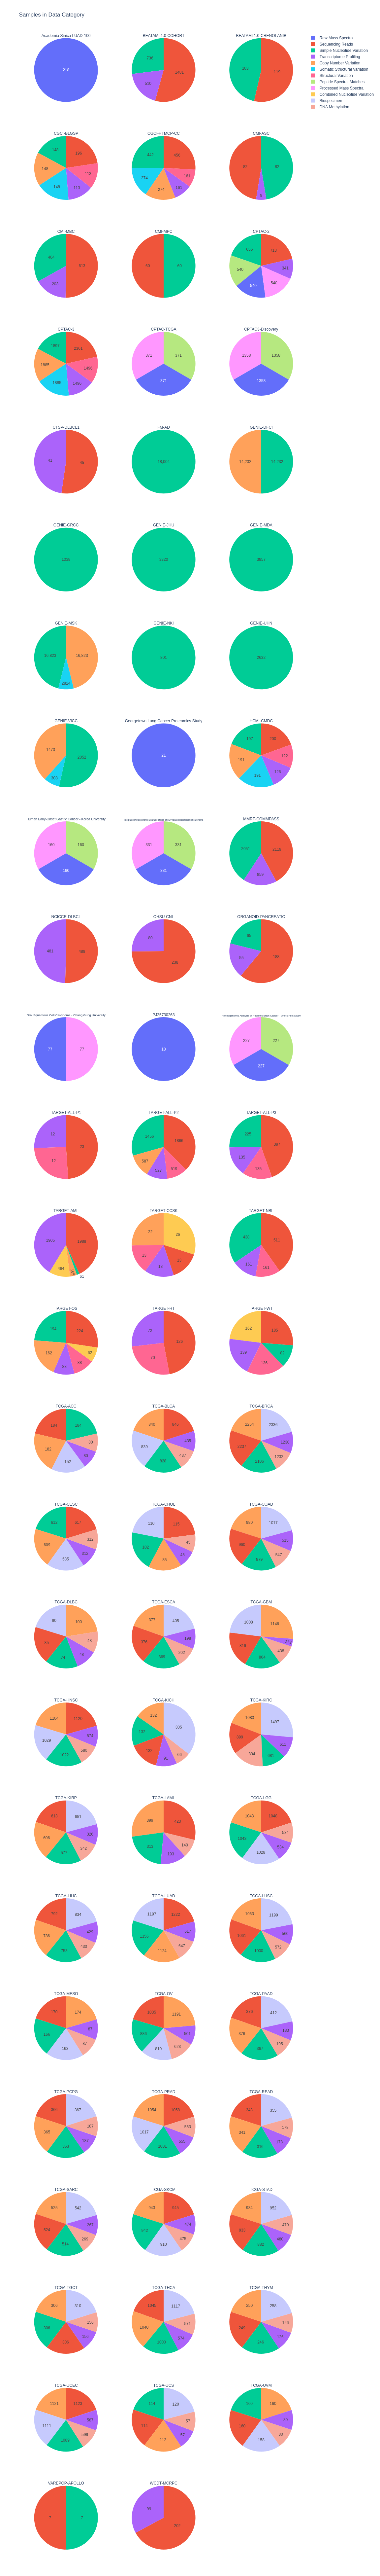

In [27]:
cols = 3
rows = math.ceil(projectcount/cols)
height =300*rows
title = 'Samples in Data Category'
plotlySubplots(countdata, cols, rows, height,title)